# 1. Albedo optimization

## Overview

In this tutorial, we will build a simple example application that showcases differentiation and optimization of a light transport simulation involving the well-known Cornell Box scene. We are going to optimize the color of one of the walls of the Cornell Box to match a target image.

Mitsuba’s ability to automatically differentiate entire rendering algorithms builds on differentiable JIT array types provided by the Dr.Jit library. Those are explained in the [Dr.Jit documentation](...). The linked document also discusses key differences compared to superficially similar frameworks like PyTorch and TensorFlow. For *automatic differentiation* (AD), Dr.Jit records and simplifies computation graphs and uses them to propagate derivatives in forward or reverse mode. Before getting further into this tutorial, we recommend that you familiarize yourself this document.

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Passing scene arguments when loading an XML file</li>
  <li>Build an optimization pipeline using the optimizer classes</li>
  <li>Perform gradient-based optimization using automatic differentiation</li>
</ul>
    
</div>


### Step 1 - setup

In order to use the automatic differentiation, we need to enable a variant that supports it. Those are the ones containing `_ad` after the backend description. E.g. `cuda_ad_rgb`, `llvm_ad_rgb`, ... 

In [1]:
# Add mitsuba and drjit to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../build/python')

In [2]:
from matplotlib import pyplot as plt

import drjit as dr 
import mitsuba as mi
mi.set_variant('cuda_ad_rgb')

It is possible to pass arguments directly to the scene via the `load_file` rountine.

In [3]:
# TODO would be great no to have to do this!
dr.set_flag(dr.JitFlag.LoopRecord,  False)

scene = mi.load_file('../scenes/cbox.xml', res=128, max_depth=3)
params = mi.traverse(scene)

2022-02-14 16:37:33 INFO main [xml.cpp:1260] Loading XML file "../scenes/cbox.xml" with variant "cuda_ad_rgb"..

2022-02-14 16:37:33 INFO main [Scene] Building scene in OptiX ..

2022-02-14 16:37:33 INFO main [Scene] OptiX ready. (took 36ms)

2022-02-14 16:37:33 INFO main [xml.cpp:1319] Done loading XML file "../scenes/cbox.xml" (took 54ms).

As we enabled a differentiable variant, when printing `params` you will notice the asterisk (`*`) on the left of some parameters which indicates that they are differentiable.

``` python
print(params)

# Output
SceneParameters[
    ...
    redwall.to_world,
  * redwall.bsdf.reflectance.value,
    redwall.vertex_count,
    redwall.face_count,
    redwall.faces,
  * redwall.vertex_positions,
  * redwall.vertex_normals,
  * redwall.vertex_texcoords,
    ...
]
```

### Step 2 - reference image

Our first experiment is going to be very simple: we will change the color of the red wall and then try to recover the original color using differentiation along with the reference image generated above. 

Before starting the optimization process, let's generate a reference image that will be used by the objective function. In contrast to the previous tutorial using `mitsuba.render` to render images, the differentiable rendering pipeline  involves another rendering function `mitsuba.render` that is more optimized for this use case as it directly returns a JIT array containing the generated image. As we will soon discover, this function also takes arguments related to differential rendering.

The `mitsuba.ad` submodule also provides a helper function to reshapes the output into an image of the correct size and exports it to any of the supported image formats (OpenEXR, PNG, JPG, RGBE, PFM) while automatically performing format conversion and gamma correction in the case of an 8-bit output format. The `write_async` argument can be used to performed this task asynchronously which is really handy when one wants to write images during the optimization process.

In [4]:
from mitsuba.util import write_bitmap, convert_to_bitmap

integrator = scene.integrator()
image_ref = integrator.render(scene, seed=0, spp=8)
write_bitmap('out_ref.png', image_ref)

2022-02-14 16:37:33 INFO main [SamplingIntegrator] Starting render job (128x128, 8 samples)

2022-02-14 16:37:33 INFO main [SamplingIntegrator] Rendering finished. (took 34ms)

It is also possible to convert the data iamge to a `mitsuba.Bitmap` object and display it using `matplotlib.

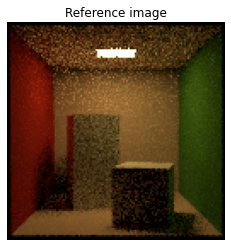

In [5]:
def show_image(img, title):
    plt.imshow(convert_to_bitmap(img)); plt.axis('off'); plt.title(title);
    plt.show()
    
show_image(image_ref, 'Reference image')

Let’s make a backup copy of this color value for later use and set it's value to a blue-ish color. As always, it is important not to forget to call `params.update()` to inform changed scene objects that they should refresh their internal state. 

This will be our initial state for the optimization process, which we can render and display to attest the difference.

2022-02-14 16:37:33 INFO main [SamplingIntegrator] Starting render job (128x128, 8 samples)

2022-02-14 16:37:33 INFO main [SamplingIntegrator] Rendering finished. (took 25ms)

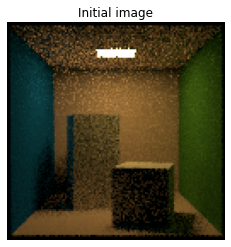

In [6]:
key = 'redwall.bsdf.reflectance.value'

params.keep([key])
param_ref = mi.Color3f(params[key])

params[key] = mi.Color3f(0.01, 0.2, 0.9)
params.update()

image_init = integrator.render(scene, seed=0, spp=8)
show_image(image_init, 'Initial image')
write_bitmap('out_init.png', image_init)

TODO talk about `Optimizer`...

In most cases, we will only be interested in differentiating a small subset of the (typically very large) parameters in the scene graph. It is responsability of the user to specify which parameters should be optimized and this can be done using the `load` method, which support list of keys and regular expressions as input argument to specify more than one parameter at a time.

In [7]:
opt = mi.ad.Adam(lr=0.05, params=params)
opt.load(key)
opt.update()

In [8]:
mi.set_log_level(mi.LogLevel.Warn)

errors = []
for it in range(50):
    # Perform a differentiable rendering of the scene
    # TODO: render separately to do unbiased=True
    image = integrator.render(scene, seed=it, spp=1)

    #write_bitmap('out_%03i.png' % it, image)

    # Objective: MSE between 'image' and 'image_ref'
    ob_val = dr.hsum_async(dr.sqr(image - image_ref)) / len(image)

    # Back-propagate errors to input parameters
    dr.backward(ob_val)

    # Optimizer: take a gradient step
    opt.step()

    opt[key] = dr.clamp(opt[key], 0.0, 1.0)

    # Optimizer: Update the scene parameters
    opt.update()

    err_ref = dr.hsum(dr.sqr(param_ref - params[key]))
    print('Iteration %03i: error=%g' % (it, err_ref[0]))
    errors.append(err_ref)

print('Optimization complete!')

Iteration 000: error=0.920876
Iteration 001: error=0.787074
Iteration 002: error=0.668325
Iteration 003: error=0.563611
Iteration 004: error=0.471308
Iteration 005: error=0.388277
Iteration 006: error=0.315938
Iteration 007: error=0.253294
Iteration 008: error=0.199912
Iteration 009: error=0.154938
Iteration 010: error=0.117541
Iteration 011: error=0.0874071
Iteration 012: error=0.0635831
Iteration 013: error=0.0451127
Iteration 014: error=0.0311418
Iteration 015: error=0.0210328
Iteration 016: error=0.0144782
Iteration 017: error=0.010534
Iteration 018: error=0.0082376
Iteration 019: error=0.00802943
Iteration 020: error=0.00973042
Iteration 021: error=0.013412
Iteration 022: error=0.0173195
Iteration 023: error=0.021147
Iteration 024: error=0.0251627
Iteration 025: error=0.0286435
Iteration 026: error=0.0315716
Iteration 027: error=0.0343316
Iteration 028: error=0.0366479
Iteration 029: error=0.0387031
Iteration 030: error=0.0400061
Iteration 031: error=0.0408089
Iteration 032: error

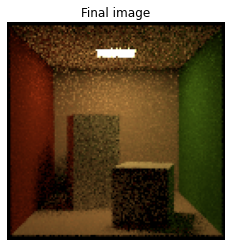

In [9]:
image_final = integrator.render(scene, seed=0, spp=8)
show_image(image_final, 'Final image')
write_bitmap('out_final.png', image_final)

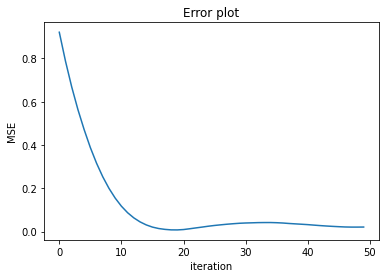

In [10]:
plt.plot(errors)
plt.xlabel('iteration'); plt.ylabel('MSE'); plt.title('Error plot');
plt.show()

### *Reference API*

- [<code>mitsuba.load_file</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.load_file)